# MNE-RSA: representational similarity analysis on sensor-level MEG data
<img src="images/novice.png" width="220" style="float: right">
Ok, let's go!

The dataset we will be working with today is the [Wakeman & Nelson (2015) "faces" dataset](https://www.nature.com/articles/sdata20151). During this experiment, participants were presented with a series of images, containing:
 - Faces of famous people that the participants likely knew
 - Faces of people that the participants likely did not know
 - Scrambled faces: the images were cut-up and randomly put together again

In this tutorial, we are going to use this dataset to explore the neural representational code within the visual cortex.
From time to time, there will be green blocks indicating it's up to you to do something, like this one:

<div class="alert alert-success">
<b>EXERCISE</b>:
    
In the cell below, update the `data_path` variable to point to where you have extracted the [`rsa-data.zip`](https://github.com/wmvanvliet/neuroscience_tutorials/releases/download/2/rsa-data.zip) file to.

(If you are running this on MyBinder then the data is located in the `data` folder).
</div>

In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 90  # Tune this to make figures bigger/smaller

# Set this to where you've extracted `data.zip` to
data_path = "data"

## A representational code for the stimuli

Let's start by taking a look at the stimuli that were presented during the experiment.
I've put them in the `stimuli` folder for you as `.bmp` image files.
The Python Imaging Library (PIL) can open them and display them in this notebook.
We can use the notebook's native [`IPython.display.display`](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#IPython.display.display) function if we want to display more than one image at once.

Famous face: 128 x 162 pixels


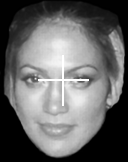

Scrambled face: 128 x 162 pixels


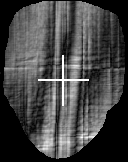

In [2]:
from PIL import Image
from IPython.display import display

# Show the first "famous" face and the first "scrambled" face
img_famous = Image.open(f"{data_path}/stimuli/f001.bmp")
img_scrambled = Image.open(f"{data_path}/stimuli/s001.bmp")

print(f"Famous face: {img_famous.width} x {img_famous.height} pixels")
display(img_famous)
print(f"Scrambled face: {img_scrambled.width} x {img_scrambled.height} pixels")
display(img_scrambled)

Loaded like this, the stimuli are in a representational space defined by their pixels.
Each image is represented by 128 x 162 = 20736 values between 0 (black) and 255 (white).
Let's create a Representational Dissimilarity Matrix (RDM) where images are compared based on the difference between their pixels.
To get the pixels of an image, you can convert it to a NumPy array like this:

In [3]:
import numpy as np
pixels_famous = np.array(img_famous)
pixels_scrambled = np.array(img_scrambled)

print("Shape of the pixel array for the famous face:", pixels_famous.shape)
print("Shape of the pixel array for the scrambled face:", pixels_scrambled.shape)

Shape of the pixel array for the famous face: (162, 128)
Shape of the pixel array for the scrambled face: (162, 128)


We can now compute the "dissimilarity" between the two images, based on their pixels.
For this, we need to decide on a metric to use.
The default metric used in the original publication ([Kiegeskorte et al. 2008](https://www.frontiersin.org/articles/10.3389/neuro.06.004.2008/full)) was Pearson Correlation, so let's use that.
Of course, correlation is a metric of similarity and we want a metric of *dis*similarity.
Let's make it easy on ourselves and just do $1 - r$.

In [4]:
from scipy.stats import pearsonr
similarity, _ = pearsonr(pixels_famous.flatten(), pixels_scrambled.flatten())
dissimilarity = 1 - similarity
print(f"The dissimilarity between the pixels of the famous and scrambled faces is: {dissimilarity:.3f}")

The dissimilarity between the pixels of the famous and scrambled faces is: 0.418


To construct the full RDM, we need to do this for all pairs of images.
I'll talk you through the process, but I will let you do the coding for this.
Ready? Let's go!

<div class="alert alert-success">
<b>EXERCISE</b>:
    
In the cell below, I've already constructed a list of all image files for you.
For first task is to load all of them (there are 450), convert them to NumPy arrays and concatenate them all together in a single big array called `pixels` of shape `n_images x width x height`.
</div>

In [5]:
from glob import glob
files = sorted(glob(f"{data_path}/stimuli/*.bmp"))
print(f"There are {len(files)} images to read.")

pixels =  np.array([np.array(Image.open(f)) for f in files])# write your code here

There are 450 images to read.


If you did it correctly, then executing the cell below should tell us the shape of your big array, and verify its dimensions.

In [6]:
print("The dimensions of the `pixel` array are:", pixels.shape) 
if pixels.shape == (450, 162, 128):
    print("These dimensions are correct! 😊")
else:
    print("These dimensions are not correct. 🤔")

The dimensions of the `pixel` array are: (450, 162, 128)
These dimensions are correct! 😊


## Your first RDM

Now that you have all the images loaded in, computing the pairwise dissimilarities is a matter of looping over them and computing correlations.
We could do this manually, but we can make our life a lot easier by using MNE-RSA's [`compute_rdm`](https://users.aalto.fi/~vanvlm1/mne-rsa/functions/mne_rsa.compute_rdm.html) function.
It wants the big matrix as input and also takes a `metric` parameter to select which dissimilarity metric to use.
Setting it to `metric="correlation"`, which is also the default by the way, will make it use (1 - Pearson correlation) as a metric like we did manually above.

<div class="alert alert-success">
<b>EXERCISE</b>:
    
In the cell below, I've imported the function for you.
I'll leave it up to you to call it properly (check [its documentation](https://users.aalto.fi/~vanvlm1/mne-rsa/functions/mne_rsa.compute_rdm.html) if you're unsure).
</div>

In [8]:
from mne_rsa import compute_rdm
pixel_rdm = compute_rdm(pixels) # write the call to compute_dsm() here

If you did it correctly, executing the cell below will plot your RDM:

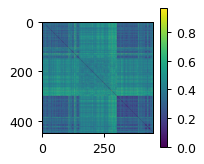

In [9]:
from mne_rsa import plot_rdms
plot_rdms(pixel_rdm);

Staring deeply into this RDM will reveal to you which images belonged to the "scrambled faces" class, as those pixels are quite different from the actual faces and each other.
We also see that for some reason, the famous faces are a little more alike than the unknown faces.

The diagonal is all zeros. Take a moment to ponder why that would be.

<div class="alert alert-block alert-info">
    <b>IMPLEMENTATION DETAIL</b><br>
    The <code>compute_rdm</code> function is a wrapper around <code>scipy.spatial.distance.pdist</code>.
    This means that all the metrics supported by <code>pdist</code> are also valid for <code>compute_dsm</code>.
    This also means that in MNE-RSA, the native format for an RDM is the so-called "condensed" form.
    Since RDMs are symmetric, only the upper triangle is stored.
    The <code>scipy.spatial.distance.squareform</code> function can be used to go from a square matrix to its condensed form and back.
</div>

## Your second RDM

There are many sensible representations possible for images.
One intriguing one is to create them using convolutional neural networks (CNNs).
For example, there is the [FaceNet](https://github.com/davidsandberg/facenet) model by [Schroff et al. (2015)](http://arxiv.org/abs/1503.03832) that can generate high-level representations, such that different photos of the same face have similar representations.
I have run the stimulus images through FaceNet and recorded the generated embeddings for you to use:

In [10]:
store = np.load(f"{data_path}/stimuli/facenet_embeddings.npz")
filenames = store["filenames"]
embeddings = store["embeddings"]
print(f"For each of the 450 images, the embedding is a vector of length 512: {embeddings.shape}")

For each of the 450 images, the embedding is a vector of length 512: (450, 512)


<div class="alert alert-success">
<b>EXERCISE</b>:
    
I leave it up to you to construct the RDM based on the FaceNet embedding vectors using the [`compute_rdm`](https://users.aalto.fi/~vanvlm1/mne-rsa/functions/mne_rsa.compute_rdm.html) function.
Use Pearson correlation as dissimility metric and store the RDM in a variable called `facenet_rdm`.
Make sure that the stimuli are in the same order as the pixel RDM we created earlier!
</div>

In [13]:
facenet_rdm = compute_rdm(embeddings) # write your code here

If you created the FaceNet RDM correctly, executing the cell below should plot both RDMs side-by-side:

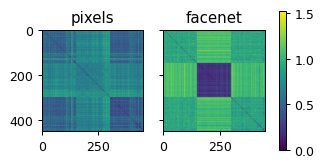

In [14]:
plot_rdms([pixel_rdm, facenet_rdm], names=["pixels", "facenet"]);

## A look at the brain data

We've seen how we can create RDMs using properties of the images or embeddings generated by a model.
Now it's time to see how we create RDMs based on the MEG data.
For that, we first load the epochs from a single participant.

In [15]:
import mne
epochs = mne.read_epochs(f"{data_path}/sub-02/sub-02-epo.fif")
epochs

Reading /home/vanvlm1/projects/neuroscience_tutorials/rsa/data/sub-02/sub-02-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    2900.00 ms
        0 CTF compensation matrices available
Adding metadata with 2 columns
879 matching events found
No baseline correction applied
0 projection items activated


<EpochsFIF | 879 events (all good), -0.2 – 2.9 s (baseline -0.2 – 0 s), ~1.40 GiB, data loaded, with metadata,
 'face/famous/first': 147
 'face/famous/immediate': 78
 'face/famous/long': 66
 'face/unfamiliar/first': 149
 'face/unfamiliar/immediate': 65
 'face/unfamiliar/long': 79
 'scrambled/first': 150
 'scrambled/immediate': 71
 'scrambled/long': 74>

Each epoch corresponds to the presentation of an image, and the signal across the sensors over time can be used as the neural representation of that image.
Hence, one could make a neural RDM, of for example the gradiometers, like this:

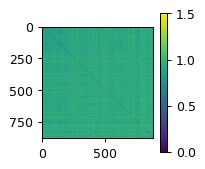

In [16]:
neural_rdm = compute_rdm(epochs.copy().pick("grad").crop(0.1, 0.2).get_data())
plot_rdms(neural_rdm);

To compute RSA scores, we want to compare the resulting neural RDM with the RDMs we've created earlier.
However, if we inspect the neural RDM closely, we see that its rows and column don't line up with those of the previous RDMs.
There are too many (879 vs. 450) and they are in the wrong order. Making sure that the RDMs match is an important and sometimes tricky part of RSA.

To help us out, a useful feature of MNE-Python is that epochs have an associated [`epochs.metadata`](https://mne.tools/stable/auto_tutorials/epochs/30_epochs_metadata.html) field.
This metadata is a [Pandas DataFrame](https://pandas.pydata.org/docs/user_guide/dsintro.html#dataframe) where each row contains information about the corresponding epoch.
The epochs in this tutorial come with some useful `.metadata` already:

In [17]:
epochs.metadata

,trigger,file
0,13,u032.bmp
1,14,u032.bmp
2,13,u088.bmp
3,13,u084.bmp
4,5,f123.bmp
...,...,...
882,5,f016.bmp
883,6,f016.bmp
884,5,f002.bmp
885,6,f002.bmp


While the trigger codes only indicate what type of stimulus was shown, the `file` column of the metadata tells us the exact image.
Couple of challenges here: the stimuli where shown in a random order, stimuli were repeated twice during the experiment, and some epochs were dropped during preprocessing so not every image is necessarily present twice in the `epochs` data. 😩

Luckily, MNE-RSA has a way to make our lives easier.
Let's take a look at the [`rdm_epochs`](https://users.aalto.fi/~vanvlm1/mne-rsa/functions/mne_rsa.rdm_epochs.html) function, the Swiss army knife for computing RDMs from an MNE-Python `epochs` object:

In [19]:
from mne_rsa import rdm_epochs
rdm_epochs?

Signature:
rdm_epochs(
    epochs,
    noise_cov=None,
    spatial_radius=None,
    temporal_radius=None,
    dist_metric='correlation',
    dist_params={},
    y=None,
    n_folds=1,
    picks=None,
    tmin=None,
    tmax=None,
    dropped_as_nan=False,
)
Docstring:
Generate RDMs in a searchlight pattern on epochs.

Parameters
----------
epochs : instance of mne.Epochs
    The brain activity during the epochs. The event codes are used to distinguish
    between items.
noise_cov : mne.Covariance | None
    When specified, the data will by normalized using the noise covariance. This is
    recommended in all cases, but a hard requirement when the data contains sensors
    of different types. Defaults to None.
spatial_radius : floats | None
    The spatial radius of the searchlight patch in meters. All sensors within this
    radius will belong to the searchlight patch. Set to None to only perform the
    searchlight over time, flattening across sensors. Defaults to None.
temporal_radiu

In MNE-Python tradition, the function has a lot of parameters, but all-but-one have a default so you only have to specify the ones that are relevant to you.
For example, to redo the neural RDM we created above, we could do something like:

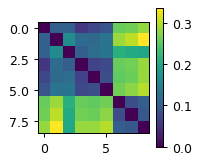

In [20]:
neural_rdm_gen = rdm_epochs(epochs, tmin=0.1, tmax=0.2)

# dsm_epochs returns a generator of RDMs
# unpacking the first (and only) RDM from the generator
neural_rdm = next(neural_rdm_gen)
plot_rdms(neural_rdm);

Take note that [`rdm_epochs`](https://users.aalto.fi/~vanvlm1/mne-rsa/functions/mne_rsa.rdm_epochs.html) returns a [generator](https://wiki.python.org/moin/Generators) of RDMs.
This is because one of the main use-cases for MNE-RSA is to produce RDMs using sliding windows (in time and also in space), which can produce a large amount of RDMs that can take up a lot of memory of you're not careful.

## The `y` parameter that solves ~~all~~ most alignment problems
Looking at the neural RDM above, something is clearly different from the one we made before.
This one has 9 rows and columns.
Closely inspecting the docstring of [`rdm_epochs`](https://users.aalto.fi/~vanvlm1/mne-rsa/functions/mne_rsa.rdm_epochs.html) reveals that it is the `y` parameter that is responsible for this:

```
y : ndarray of int, shape (n_items,) | None
    For each Epoch, a number indicating the item to which it belongs. When
    None, the event codes are used to differentiate between items.
    Defaults to None.
```

Instead of producing one row per epoch, [`rdm_epochs`](https://users.aalto.fi/~vanvlm1/mne-rsa/functions/mne_rsa.rdm_epochs.html) produced one row per event type, averaging across epochs of the same type before computing dissimilarity.
This is not quite what we want though.
If we want to match `pixel_rdm` and `facenet_rdm`, we want every single one of the 450 images to be its own stimulus type.

<div class="alert alert-success">
<b>EXERCISE</b>:
    
Turning it over to you: in the cell below, write the code necessary to construct the desired neural RDM.
This is your first real challenge in this workshop.
Keep the following in mind:

 - Each of the 450 images should be on a row by itself
 - We will achieve this by setting the `y` parameter of [`rdm_epochs`](https://users.aalto.fi/~vanvlm1/mne-rsa/functions/mne_rsa.rdm_epochs.html) to a list that assigns each of the 879 epochs to a number from 1-450 (or 0-449) indicating which image was shown. Take care to assign number according to the order in which they appear in `pixel_rdm` and `facenet_rdm`.
 - An image is identified by its filename, and we have the `files` and `filenames` variables left over from earlier that contain all the images in the proper order.
 - The `epochs.metadata["file"]` column contains the filenames corresponding to the epochs.
 - Tell [`rdm_epochs`](https://users.aalto.fi/~vanvlm1/mne-rsa/functions/mne_rsa.rdm_epochs.html) to only consider data from 0.1 to 0.2 seconds.
 - The result will be a generator. Use `next()` to unpack the RDM from it.
</div>

In [21]:
epochs.metadata

,trigger,file
0,13,u032.bmp
1,14,u032.bmp
2,13,u088.bmp
3,13,u084.bmp
4,5,f123.bmp
...,...,...
882,5,f016.bmp
883,6,f016.bmp
884,5,f002.bmp
885,6,f002.bmp


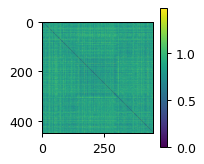

In [25]:
y = [list(filenames).index(f) for f in epochs.metadata.file]# compute y here
neural_rdm = next(rdm_epochs(epochs, y=y, tmin=0.1, tmax=0.2)) # compute the RDM here

# This plots your RDM
plot_rdms(neural_rdm);

If you've done it correctly, the cell below will compure RSA between the neural RDM and the pixel and FaceNet RDMs we created earlier.
The RSA score will be the Spearman correlation between the RDMs, which is the default metric used in the [original RSA paper](https://www.frontiersin.org/articles/10.3389/neuro.06.004.2008/full).

In [26]:
from mne_rsa import rsa
rsa_pixel = rsa(neural_rdm, pixel_rdm, metric="spearman")
rsa_facenet = rsa(neural_rdm, facenet_rdm, metric="spearman")

print("RSA score between neural RDM and pixel RDM:", rsa_pixel)
print("RSA score between neural RDM and FaceNet RDM:", rsa_facenet)

RSA score between neural RDM and pixel RDM: 0.07869920694906636
RSA score between neural RDM and FaceNet RDM: 0.07529582461337744


## Slippin' and slidin' across time

The neural representation of a stimulus is different across brain regions and evolves over time.
For example, we would expect that the pixel RDM would be more similar to a neural RDM that we computed across the visual cortex at an early time point, and that the FaceNET RDM might be more similar to a neural RDM that we computed at a later time point.

For the remainder of this notebook, we'll restrict the `epochs` to only contain the sensors over the left occipital cortex.

<div class="alert alert-block alert-warning">
    <b>IMPORTANT NOTE</b><br>
    Just because we select sensors over a certain brain region, does not mean the magnetic fields originate from that region.
    This is especially true for magnetometers. To make it a bit more accurate, we only select gradiometers.
</div>

In [27]:
picks = mne.channels.read_vectorview_selection("Left-occipital")
picks = ["".join(p.split(" ")) for p in picks]
epochs.pick(picks).pick("grad").crop(-0.1, 1)

<EpochsFIF | 879 events (all good), -0.1 – 1 s (baseline -0.2 – 0 s (baseline period was cropped after baseline correction)), ~45.7 MiB, data loaded, with metadata,
 'face/famous/first': 147
 'face/famous/immediate': 78
 'face/famous/long': 66
 'face/unfamiliar/first': 149
 'face/unfamiliar/immediate': 65
 'face/unfamiliar/long': 79
 'scrambled/first': 150
 'scrambled/immediate': 71
 'scrambled/long': 74>

<div class="alert alert-success">
<b>EXERCISE</b>:
    
In the cell below, use [`rdm_epochs`](https://users.aalto.fi/~vanvlm1/mne-rsa/functions/mne_rsa.rdm_epochs.html) to compute RDMs using a sliding window by setting the `temporal_radius` parameter to `0.1` seconds.
Use the entire time range (`tmin=None` and `tmax=None`) and leave the result as a generator (so no `next()` calls).
Store the resulting generator in a variable called `neural_dsms_gen`.
</div>

In [30]:
neural_rdms_gen = rdm_epochs(epochs, y=y, temporal_radius=0.1) # write your call to rdm_epochs() here

If you did it correctly, the cell below will consume the generator (with a nice progress bar) and plot a few of the generated RDMs:

  0%|                                                                                         | 0/199 [00:00<?, ?it/s]

Creating temporal searchlight patches


100%|███████████████████████████████████████████████████████████████████████████████| 199/199 [00:05<00:00, 36.63it/s]


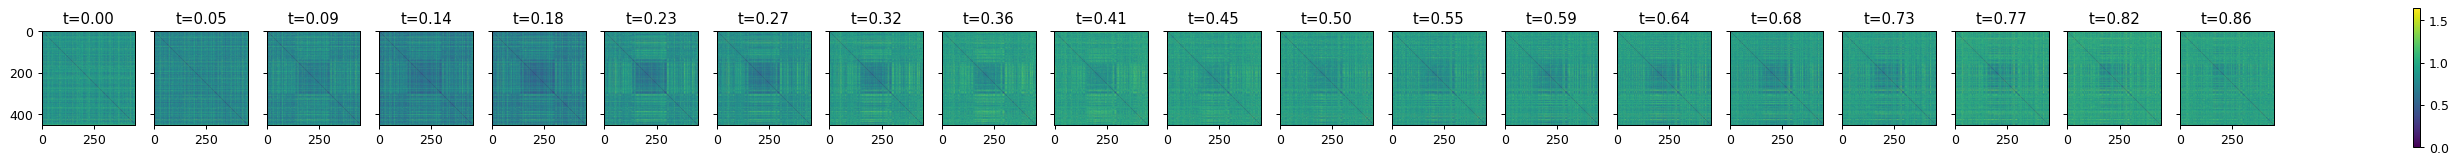

In [31]:
from tqdm import tqdm
times = epochs.times[(epochs.times >= 0) & (epochs.times <= 0.9)]
neural_rdms_list = list(tqdm(neural_rdms_gen, total=len(times)))
plot_rdms(neural_rdms_list[::10], names=[f"t={t:.2f}" for t in times[::10]]);

## Putting it altogether for sensor-level RSA

Now all that is left to do is compute RSA scored between the neural RDMs you've just created and the pixel and FaceNet RDMs.
We could do this using the [`rsa_gen`](https://users.aalto.fi/~vanvlm1/mne-rsa/functions/mne_rsa.rsa_gen.html) function, but I'd rather directly show you the [`rsa_epochs`](https://users.aalto.fi/~vanvlm1/mne-rsa/functions/mne_rsa.rsa_epochs.htm) function that combines computing the neural RDMs with computing the RSA scores:

In [32]:
from mne_rsa import rsa_epochs
rsa_epochs?

Signature:
rsa_epochs(
    epochs,
    rdm_model,
    noise_cov=None,
    spatial_radius=None,
    temporal_radius=None,
    epochs_rdm_metric='correlation',
    epochs_rdm_params={},
    rsa_metric='spearman',
    ignore_nan=False,
    y=None,
    n_folds=1,
    picks=None,
    tmin=None,
    tmax=None,
    dropped_as_nan=False,
    n_jobs=1,
    verbose=False,
)
Docstring:
Perform RSA in a searchlight pattern on epochs.

The output is an Evoked object where the "signal" at each sensor is the RSA,
computed using all surrounding sensors.

Parameters
----------
epochs : instance of mne.Epochs
    The brain activity during the epochs. The event codes are used to distinguish
    between items.
rdm_model : ndarray, shape (n, n) | (n * (n - 1) // 2,) | list of ndarray
    The model RDM, see :func:`compute_rdm`. For efficiency, you can give it in
    condensed form, meaning only the upper triangle of the matrix as a vector. See
    :func:`scipy.spatial.distance.squareform`. To perform RSA ag

The signature of [`rsa_epochs`](https://users.aalto.fi/~vanvlm1/mne-rsa/functions/mne_rsa.rsa_epochs.htm) is very similar to that of [`dsm_epochs`](https://users.aalto.fi/~vanvlm1/mne-rsa/functions/mne_rsa.dsm_epochs.html).
The main difference is that we also give it the "model" RDMs, in our case the pixel and FaceNet RDMs.
[`rsa_epochs`](https://users.aalto.fi/~vanvlm1/mne-rsa/functions/mne_rsa.rsa_epochs.htm) will return the RSA scores as a list of `mne.Evoked` objects: one for each model RDM we gave it.

<div class="alert alert-success">
<b>EXERCISE</b>:
    
Go ahead and:
 - compute the RSA scores for `epochs` gainst `[pixel_rdm, facenet_rdm]`
 - do this in a sliding windows across time, with a temporal radius of 0.1 seconds
 - optionally set `verbose=True` to activate a progress bar
 - optionally set `n_jobs=-1` to use multiple CPU cores to speed things up
 - store the result in a variable called `ev_rsa`
</div>

In [33]:
ev_rsa = rsa_epochs(epochs, [pixel_rdm, facenet_rdm], y=y, temporal_radius=0.1)

Performing RSA between Epochs and 2 model RDM(s)
    Temporal radius: 22 samples
    Time interval: None-None seconds
Creating temporal searchlight patches


If you did it correctly, executing the cell below will create a nice plot of the result.

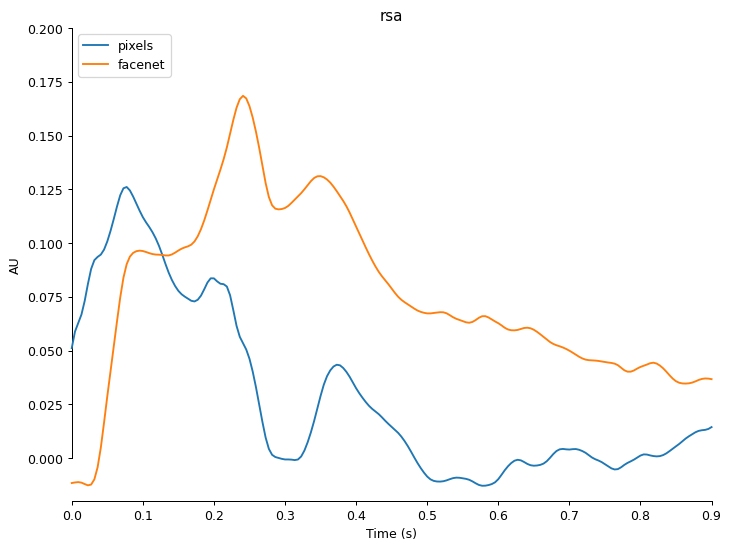

In [34]:
ev_rsa[0].comment = "pixels"
ev_rsa[1].comment = "facenet"
mne.viz.plot_compare_evokeds(ev_rsa, picks=[0], ylim=dict(misc=[-0.02, 0.2]), show_sensors=False);

If you've made it this far, you have successfully completed your first sensor-level RSA! 🎉
This is the end of this notebook.
I invite you to join me in the [next notebook](fast_source_level.ipynb) where we will do source level RSA.

<center>
<a href="source_level.ipynb"><img width="200" src="images/adept.png"></a><br>
<a href="source_level.ipynb" style="font-size: 20pt">>>>>> Continue to source-level RSA >>>>></a>
</center>